# Demo for Top-down Neural Attention

This is an example to show how to use Excitation Backprop to visualize CNN classifier's top-down attention.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import transform, filters
import sys, pylab, operator, csv
import util
import os
import urllib

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe
from caffe import layers as L
from caffe import params as P

caffe.set_mode_gpu()

import cnn_utils
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first load the model files and set the top layers' name. Let's look at the [VGG](http://www.robots.ox.ac.uk/~vgg/) groups 16 layer CNN for object classification trained on ImageNet: https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md

In [21]:
model_root_path = "/home/will/nets/dual-stream/spatial"
model_name = "kfold1borders25"

deploy_prototxt_path = os.path.join(model_root_path, "deploy.prototxt")
caffemodel_path = os.path.join(model_root_path, model_name + ".caffemodel")


net = caffe.Net(deploy_prototxt_path,
                caffemodel_path,
                caffe.TRAIN)

# The very last layer in the network (pre loss layer)
topLayerName = 'fc8'
topBlobName = net.top_names[topLayerName][0]
secondTopLayerName = 'relu7'
secondTopBlobName = net.top_names[secondTopLayerName][0]

# This is the layer we'll stop at when excitation backpropping
outputLayerName = 'pool3'

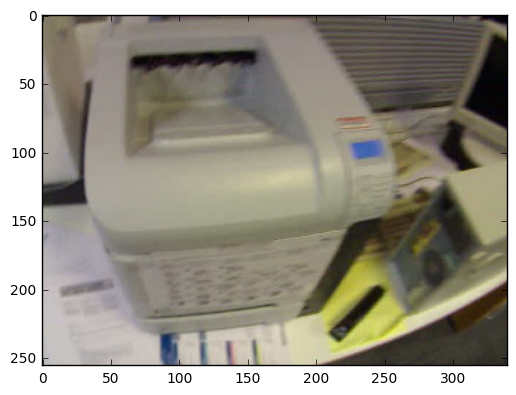

In [27]:
data_root = "/home/will/data/beoid/spatial"
#image_path = os.path.join(data_root, "desk-plug-plug/frame000084.jpg")
#image_path = os.path.join(data_root, "treadmill-press-button/frame000034.jpg")
#image_path = os.path.join(data_root, "printer-press-button/frame000010.jpg")
#image_path = os.path.join(data_root, "push_drawer/frame000057.jpg")
#image_path = os.path.join(data_root, "insert_screwdriver/frame000135.jpg")
image_path = os.path.join(data_root, "04_Printer2_push_drawer_241-293/frame000040.jpg")


image = caffe.io.load_image(image_path)
new_size = (224, 224)

net.blobs['data'].reshape(1, 3, new_size[0], new_size[1])

plt.figure(figsize=(6, 5))
plt.imshow(image)

In [23]:
cnn_utils.print_layer_shapes(net)

Layer shapes (output)

input               : [(1, 3, 224, 224), (1, 34, 1, 1)]
conv1_1             : [(1, 64, 224, 224)]
relu1_1             : [(1, 64, 224, 224)]
conv1_2             : [(1, 64, 224, 224)]
relu1_2             : [(1, 64, 224, 224)]
pool1               : [(1, 64, 112, 112)]
conv2_1             : [(1, 128, 112, 112)]
relu2_1             : [(1, 128, 112, 112)]
conv2_2             : [(1, 128, 112, 112)]
relu2_2             : [(1, 128, 112, 112)]
pool2               : [(1, 128, 56, 56)]
conv3_1             : [(1, 256, 56, 56)]
relu3_1             : [(1, 256, 56, 56)]
conv3_2             : [(1, 256, 56, 56)]
relu3_2             : [(1, 256, 56, 56)]
conv3_3             : [(1, 256, 56, 56)]
relu3_3             : [(1, 256, 56, 56)]
pool3               : [(1, 256, 28, 28)]
conv4_1             : [(1, 512, 28, 28)]
relu4_1             : [(1, 512, 28, 28)]
conv4_2             : [(1, 512, 28, 28)]
relu4_2             : [(1, 512, 28, 28)]
conv4_3             : [(1, 512, 28, 28)]
relu4_

In [28]:
transformer = cnn_utils.imagenet_transformer(net)

eb = cnn_utils.ExcitationBackprop(net, 'fc8', 'fc7', 'pool3')

net.blobs['data'].data[...] = transformer.preprocess('data', image)
eb.prop(transformer.preprocess('data', image))

class_count = 34
scores = net.blobs[eb.top_blob_name].data[0].reshape(class_count, -1).max(1).flatten() # pre-softmax scores
class_ids = scores.argsort()[-3:][::-1]

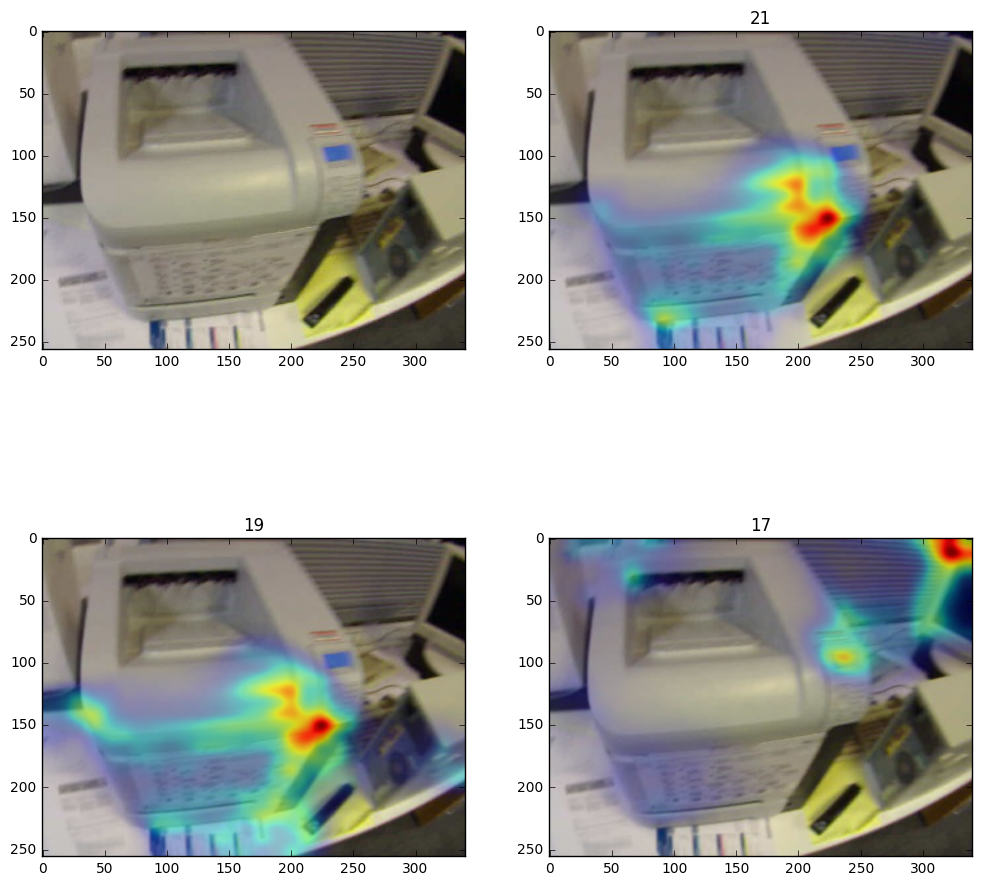

In [29]:
attMaps = []

for class_id in class_ids:
    attMap = eb..backprop(class_id)
    attMaps.append(attMap)

util.showAttMap(image, attMaps, class_ids, overlap = True, blur = False)